<a href="https://colab.research.google.com/github/jiuShiQi97/OOP_Lab/blob/master/demo11-conditional-gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Conditional GANs

Based on the excellent tutorial [here](https://github.com/Yangyangii/GAN-Tutorial/blob/master/MNIST/Conditional-GAN.ipynb).

By formulating the process as a two-player game, Generative Adversarial Networks (GANs) can be very effective in generating realistic content. However, we may want to have more control over what is generated. Conditional GANs offer more control by letting us specify the *class* of output we want. Then we hand the generated content and the class it's supposed to be to the discriminator. The disciminator attempts to differentiate between the generated content of a certain class and the real content of a certain class.

The original paper that described conditional GANs is [here](https://arxiv.org/abs/1411.1784).

![](https://salu133445.github.io/dan/figs/cgan.png)


## Libaries

As always, we load lots of libraries.

In [1]:
import torch
from torchvision import datasets
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
import os
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

## Data

For this demo, we will be using the MNIST data set. We can apply GANs to other datasets but the training process takes much longer. Our goal will be to supply random noise and a class label (e.g. a digit between 0 and 9) to the generator and produce an image of that particular digit.

In [2]:
# A transform to convert the images to tensor and normalize their RGB values
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5], std=[0.5])]
)

data = datasets.MNIST(root='../data/', train=True, transform=transform, download=True)

batch_size = 64
data_loader = DataLoader(dataset=data, batch_size=batch_size, shuffle=True, drop_last=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 60.8MB/s]


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.68MB/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 13.8MB/s]


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.97MB/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



## Helper Functions

We'll need several helper functions for training the conditional GAN. The first converts labels to one hot encoded vectors, we will use it to pass the desired label to the generator. The second will plot a grid of 10x10 images from the generator.

In [3]:
def to_onehot(x, num_classes=10):
    assert isinstance(x, int) or isinstance(x, (torch.LongTensor, torch.cuda.LongTensor))
    if isinstance(x, int):
        c = torch.zeros(1, num_classes).long()
        c[0][x] = 1
    else:
        x = x.cpu()
        c = torch.LongTensor(x.size(0), num_classes)
        c.zero_()
        c.scatter_(1, x, 1) # dim, index, src value
    return c

In [4]:
to_onehot(3)

tensor([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]])

In [5]:
def get_sample_image(G, DEVICE, n_noise=100):
    img = np.zeros([280, 280])
    for j in range(10):
        c = torch.zeros([10, 10]).to(DEVICE)
        c[:, j] = 1
        z = torch.randn(10, n_noise).to(DEVICE)
        y_hat = G(z,c).view(10, 28, 28)
        result = y_hat.cpu().data.numpy()
        img[j*28:(j+1)*28] = np.concatenate([x for x in result], axis=-1)
    return img

## Architecture

We now instantiate the generator and discriminator architectures. The generator takes a random noise vector and a one hot encoded label as input and produces an image. The discriminator takes an image and a one hot encoded label as input and produces a single value between 0 and 1. The discriminator is trained to output 1 for real images and 0 for fake images. The generator is trained to fool the discriminator by outputting images that look real.

In [6]:
class Generator(nn.Module):
    def __init__(self, input_size=100, num_classes=10, image_size=28*28):
        super(Generator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 128), # auxillary dimension for label
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 1024),
            nn.BatchNorm1d(1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, image_size),
            nn.Tanh()
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        y_ = y_.view(x.size(0), 1, 28, 28)
        return y_

In [7]:
class Discriminator(nn.Module):
    def __init__(self, input_size=28*28, num_classes=10, num_output=1):
        super(Discriminator, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size+num_classes, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, num_output),
            nn.Sigmoid(),
        )

    def forward(self, x, c):
        x, c = x.view(x.size(0), -1), c.view(c.size(0), -1).float()
        v = torch.cat((x, c), 1) # v: [input, label] concatenated vector
        y_ = self.network(v)
        return y_

## Set up and Training

Now, we're ready to instantiate our models, hyperparameters, and optimizers. Since the task is so easy for MNIST, we will train for only 10 epochs. We will update the generator and discriminator in every step but often one can be trained more frequently than the other.

In [8]:
MODEL_NAME = 'ConditionalGAN'
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

D = Discriminator().to(DEVICE) # randomly intialized
G = Generator().to(DEVICE) # randomly initialized

max_epoch = 10
step = 0
n_noise = 100 # size of noise vector

criterion = nn.BCELoss()
D_opt = torch.optim.Adam(D.parameters(), lr=0.0002, betas=(0.5, 0.999))
G_opt = torch.optim.Adam(G.parameters(), lr=0.0002, betas=(0.5, 0.999))

# We will denote real images as 1s and fake images as 0s
# This is why we needed to drop the last batch of the data loader
all_ones = torch.ones([batch_size, 1]).to(DEVICE) # Discriminator label: real
all_zeros = torch.zeros([batch_size, 1]).to(DEVICE) # Discriminator Label: fake

In [9]:
images, class_labels = next(iter(data_loader))
class_labels_encoded = class_labels.view(batch_size, 1)
class_labels_encoded = to_onehot(class_labels_encoded).to(DEVICE)
print(class_labels[:10])
print(class_labels_encoded[:10])

tensor([0, 5, 3, 0, 6, 7, 7, 5, 8, 2])
tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0')


In [10]:
# a directory to save the generated images
if not os.path.exists('samples'):
    os.makedirs('samples')

for epoch in range(max_epoch):
    for idx, (images, class_labels) in enumerate(data_loader):
        # Training Discriminator
        x = images.to(DEVICE)
        class_labels = class_labels.view(batch_size, 1) # add singleton dimension so batch_size x 1
        class_labels = to_onehot(class_labels).to(DEVICE)
        x_outputs = D(x, class_labels) # input includes labels
        D_x_loss = criterion(x_outputs, all_ones) # Discriminator loss for real images

        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels) # input to both generator and discriminator includes labels
        D_z_loss = criterion(z_outputs, all_zeros) # Discriminator loss for fake images
        D_loss = D_x_loss + D_z_loss # Total Discriminator loss

        D.zero_grad()
        D_loss.backward()
        D_opt.step()

        # Training Generator
        z = torch.randn(batch_size, n_noise).to(DEVICE)
        z_outputs = D(G(z, class_labels), class_labels)
        G_loss = -1 * criterion(z_outputs, all_zeros) # Generator loss is negative disciminator loss

        G.zero_grad()
        G_loss.backward()
        G_opt.step()

        if step % 500 == 0:
            print('Epoch: {}/{}, Step: {}, D Loss: {}, G Loss: {}'.format(epoch, max_epoch, step, D_loss.item(), G_loss.item()))

        if step % 1000 == 0:
            G.eval()
            img = get_sample_image(G, DEVICE, n_noise)
            imsave('samples/{}_step{}.jpg'.format(MODEL_NAME, str(step).zfill(3)), img, cmap='gray')
            G.train()
        step += 1

Epoch: 0/10, Step: 0, D Loss: 1.3367555141448975, G Loss: -0.7011904120445251
Epoch: 0/10, Step: 500, D Loss: 1.1587488651275635, G Loss: -0.563438355922699
Epoch: 1/10, Step: 1000, D Loss: 1.163292646408081, G Loss: -0.5521292090415955
Epoch: 1/10, Step: 1500, D Loss: 1.0223033428192139, G Loss: -0.28699079155921936
Epoch: 2/10, Step: 2000, D Loss: 1.2236300706863403, G Loss: -0.6903836727142334
Epoch: 2/10, Step: 2500, D Loss: 1.1002908945083618, G Loss: -0.32508760690689087
Epoch: 3/10, Step: 3000, D Loss: 1.1822562217712402, G Loss: -0.5694233775138855
Epoch: 3/10, Step: 3500, D Loss: 1.315059781074524, G Loss: -0.42772021889686584
Epoch: 4/10, Step: 4000, D Loss: 1.3340821266174316, G Loss: -0.5765097141265869
Epoch: 4/10, Step: 4500, D Loss: 1.219686508178711, G Loss: -0.5901322960853577
Epoch: 5/10, Step: 5000, D Loss: 1.2955939769744873, G Loss: -0.6636669039726257
Epoch: 5/10, Step: 5500, D Loss: 1.3886301517486572, G Loss: -0.47572648525238037
Epoch: 6/10, Step: 6000, D Loss:

Now let's plot these images. At first, the generator just produces noise (as we expect).

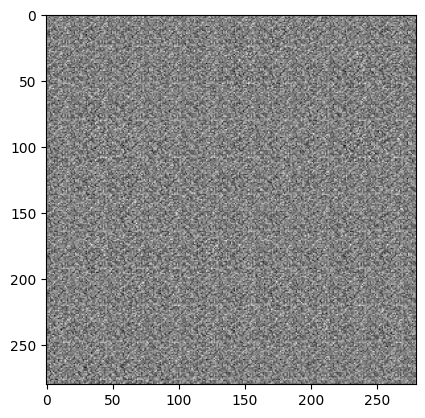

In [11]:
img = mpimg.imread('samples/ConditionalGAN_step000.jpg')
imgplot = plt.imshow(img)
plt.show()

But then it gets better.

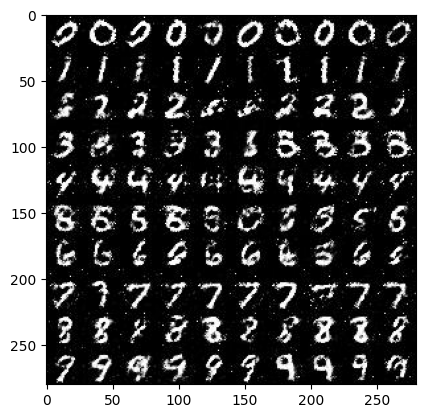

In [12]:
img = mpimg.imread('samples/ConditionalGAN_step5000.jpg')
imgplot = plt.imshow(img)
plt.show()

In fact, if we don't look too closely, we can recognize the numbers it produces.

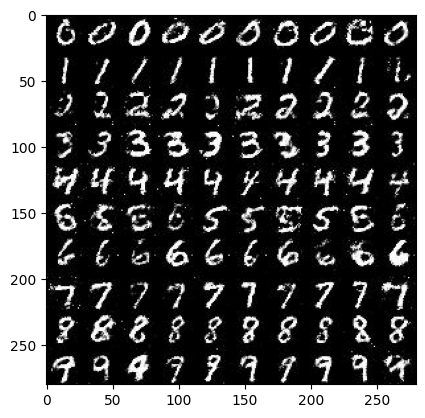

In [13]:
img = mpimg.imread('samples/ConditionalGAN_step9000.jpg')
imgplot = plt.imshow(img)
plt.show()

And by the time we're done training, even the worst images look like messy handwriting!

In [17]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
import numpy as np
from PIL import Image

# --- data preparation ---
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])  # [-1, 1]
])
train_data = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

100%|██████████| 26.4M/26.4M [00:01<00:00, 18.6MB/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 310kB/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:00<00:00, 5.61MB/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 8.81MB/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [18]:
# --- Conditional GAN ---
class ConditionalGenerator(nn.Module):
    def __init__(self, noise_dim, num_classes):
        super(ConditionalGenerator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(noise_dim + num_classes, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z, labels):
        c = self.label_emb(labels)
        x = torch.cat([z, c], dim=1)
        return self.model(x).view(-1, 1, 28, 28)

class ConditionalDiscriminator(nn.Module):
    def __init__(self, num_classes):
        super(ConditionalDiscriminator, self).__init__()
        self.label_emb = nn.Embedding(num_classes, num_classes)
        self.model = nn.Sequential(
            nn.Linear(784 + num_classes, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img, labels):
        c = self.label_emb(labels)
        x = torch.cat([img.view(img.size(0), -1), c], dim=1)
        return self.model(x)

In [19]:
# --- Standard GAN ---
class GANGenerator(nn.Module):
    def __init__(self, noise_dim):
        super(GANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(noise_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)

class GANDiscriminator(nn.Module):
    def __init__(self):
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img.view(img.size(0), -1))

In [20]:
# --- Training function ---
def train_gan(generator, discriminator, train_loader, noise_dim, epochs, is_conditional=False, num_classes=None):
    optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
    criterion = nn.BCELoss()

    for epoch in range(epochs):
        for real_imgs, labels in train_loader:
            real_imgs = real_imgs.to(device)
            batch_size = real_imgs.size(0)

            # Train Discriminator
            optimizer_D.zero_grad()
            real_labels = torch.ones(batch_size, 1).to(device)
            fake_labels = torch.zeros(batch_size, 1).to(device)

            if is_conditional:
                labels = labels.to(device)
                real_loss = criterion(discriminator(real_imgs, labels), real_labels)
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_imgs = generator(z, labels)
                fake_loss = criterion(discriminator(fake_imgs.detach(), labels), fake_labels)
            else:
                real_loss = criterion(discriminator(real_imgs), real_labels)
                z = torch.randn(batch_size, noise_dim).to(device)
                fake_imgs = generator(z)
                fake_loss = criterion(discriminator(fake_imgs.detach()), fake_labels)

            d_loss = real_loss + fake_loss
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            if is_conditional:
                g_loss = criterion(discriminator(fake_imgs, labels), real_labels)
            else:
                g_loss = criterion(discriminator(fake_imgs), real_labels)

            g_loss.backward()
            optimizer_G.step()

        print(f"Epoch [{epoch+1}/{epochs}] | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

    return generator

In [21]:
# --- Generating picture function ---
def generate_images(generator, noise_dim, filename, is_conditional=False, num_classes=None):
    generator.eval()
    with torch.no_grad():
        if is_conditional:
            z = torch.randn(64, noise_dim).to(device)
            labels = torch.randint(0, 10, (64,)).to(device)  # randomly generate 64 categories
            fake_images = generator(z, labels).cpu().view(-1, 28, 28)
        else:
            z = torch.randn(64, noise_dim).to(device)
            fake_images = generator(z).cpu().view(-1, 28, 28)

    # Display the picture, adjusted to 8 rows and 8 columns
    plt.figure(figsize=(8, 8))
    for i in range(64):
        plt.subplot(8, 8, i + 1)
        plt.imshow(fake_images[i], cmap='gray')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(filename)
    plt.show()

Epoch [1/50] | D Loss: 0.4358 | G Loss: 3.2895
Epoch [2/50] | D Loss: 0.5412 | G Loss: 2.4743
Epoch [3/50] | D Loss: 0.7585 | G Loss: 1.6904
Epoch [4/50] | D Loss: 0.5946 | G Loss: 1.5005
Epoch [5/50] | D Loss: 1.1450 | G Loss: 1.1068
Epoch [6/50] | D Loss: 0.8253 | G Loss: 2.4893
Epoch [7/50] | D Loss: 0.8223 | G Loss: 1.9900
Epoch [8/50] | D Loss: 0.9491 | G Loss: 1.8226
Epoch [9/50] | D Loss: 1.1858 | G Loss: 2.5582
Epoch [10/50] | D Loss: 1.1208 | G Loss: 1.8638
Epoch [11/50] | D Loss: 1.2712 | G Loss: 1.3486
Epoch [12/50] | D Loss: 1.3932 | G Loss: 0.9395
Epoch [13/50] | D Loss: 1.1795 | G Loss: 1.3660
Epoch [14/50] | D Loss: 1.2034 | G Loss: 1.0811
Epoch [15/50] | D Loss: 1.2663 | G Loss: 1.1761
Epoch [16/50] | D Loss: 1.3435 | G Loss: 1.3204
Epoch [17/50] | D Loss: 1.3250 | G Loss: 0.6127
Epoch [18/50] | D Loss: 1.3133 | G Loss: 0.9049
Epoch [19/50] | D Loss: 1.3299 | G Loss: 1.1374
Epoch [20/50] | D Loss: 1.2718 | G Loss: 1.0164
Epoch [21/50] | D Loss: 1.1780 | G Loss: 1.0893
E

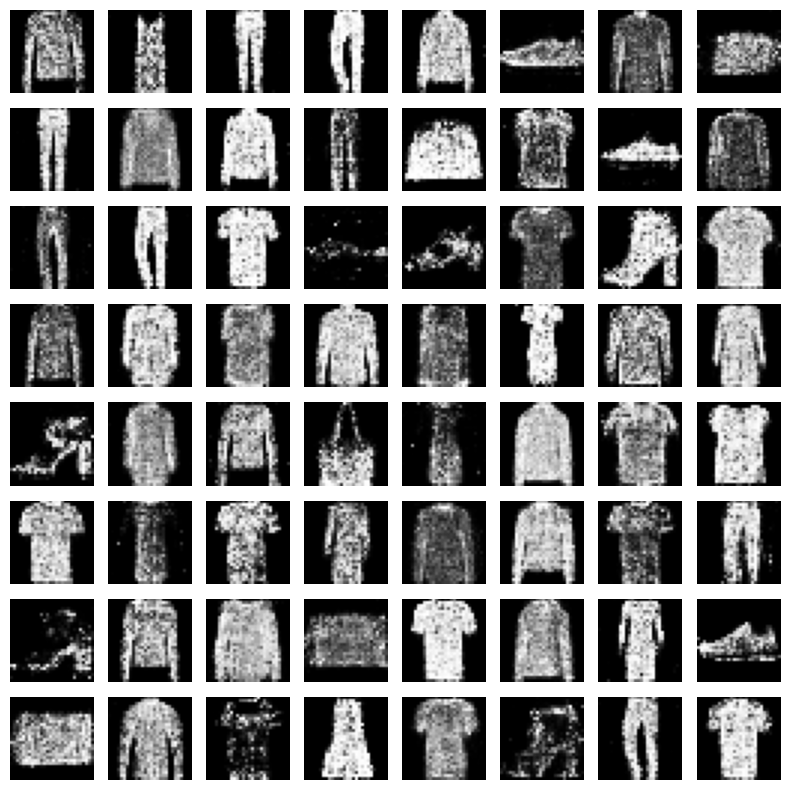

Epoch [1/50] | D Loss: 0.6158 | G Loss: 1.7682
Epoch [2/50] | D Loss: 0.3685 | G Loss: 3.3094
Epoch [3/50] | D Loss: 0.5210 | G Loss: 2.4935
Epoch [4/50] | D Loss: 0.7479 | G Loss: 1.9228
Epoch [5/50] | D Loss: 0.6073 | G Loss: 2.4251
Epoch [6/50] | D Loss: 0.8071 | G Loss: 2.8237
Epoch [7/50] | D Loss: 1.1613 | G Loss: 1.2997
Epoch [8/50] | D Loss: 0.8281 | G Loss: 1.9763
Epoch [9/50] | D Loss: 0.9859 | G Loss: 1.7259
Epoch [10/50] | D Loss: 1.1129 | G Loss: 2.1575
Epoch [11/50] | D Loss: 0.9272 | G Loss: 1.5507
Epoch [12/50] | D Loss: 1.0661 | G Loss: 1.2152
Epoch [13/50] | D Loss: 1.1112 | G Loss: 1.0850
Epoch [14/50] | D Loss: 1.2048 | G Loss: 1.4739
Epoch [15/50] | D Loss: 0.9402 | G Loss: 1.4636
Epoch [16/50] | D Loss: 1.2275 | G Loss: 2.1493
Epoch [17/50] | D Loss: 1.1569 | G Loss: 1.0939
Epoch [18/50] | D Loss: 1.1874 | G Loss: 1.5840
Epoch [19/50] | D Loss: 1.1492 | G Loss: 1.5971
Epoch [20/50] | D Loss: 1.1582 | G Loss: 1.2159
Epoch [21/50] | D Loss: 1.1547 | G Loss: 1.1403
E

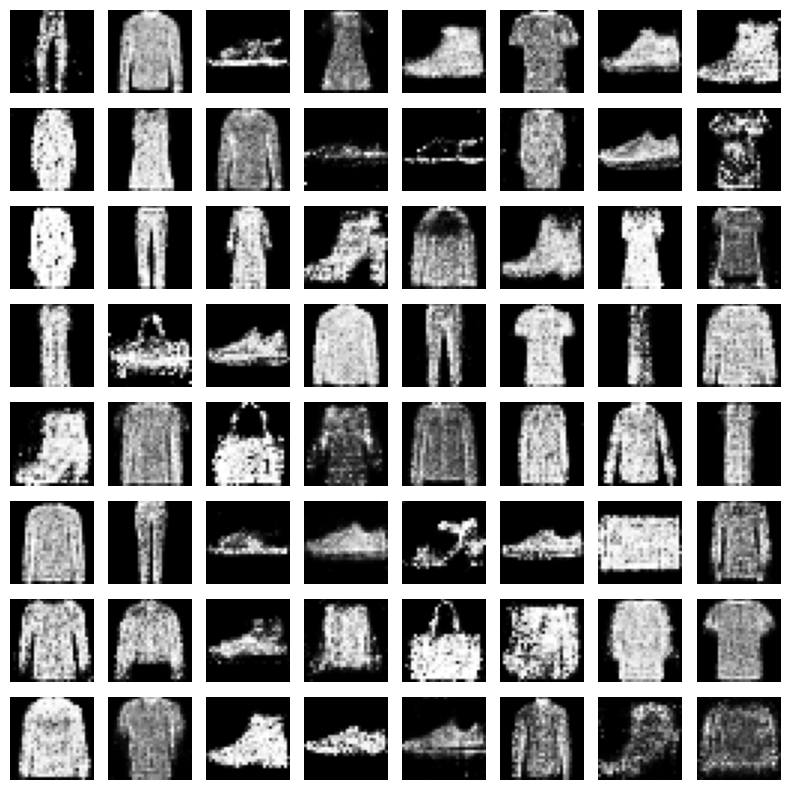

In [22]:
# --- compare two different GAN ---
noise_dim = 100
epochs = 50
num_classes = 10

# Conditional GAN
conditional_generator = ConditionalGenerator(noise_dim, num_classes).to(device)
conditional_discriminator = ConditionalDiscriminator(num_classes).to(device)
conditional_generator = train_gan(conditional_generator, conditional_discriminator, train_loader, noise_dim, epochs, is_conditional=True, num_classes=num_classes)
generate_images(conditional_generator, noise_dim, "fashionmnist_conditional_gan.png", is_conditional=True, num_classes=num_classes)

# Standard GAN
gan_generator = GANGenerator(noise_dim).to(device)
gan_discriminator = GANDiscriminator().to(device)
gan_generator = train_gan(gan_generator, gan_discriminator, train_loader, noise_dim, epochs, is_conditional=False)
generate_images(gan_generator, noise_dim, "fashionmnist_gan.png", is_conditional=False)

Real images - Mean: 0.5033, Std: 0.4009
Fake images - Mean: 0.5115, Std: 0.4017
Mean difference: 0.0083
Std difference: 0.0009
Histogram similarity: 0.9637


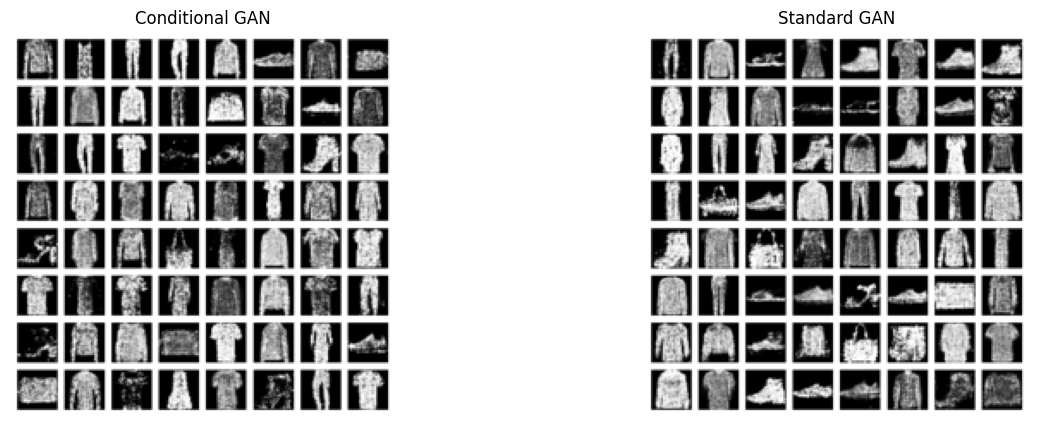

In [23]:
# --- 图片质量比较 ---
# 加载生成的图片
img_conditional = Image.open("fashionmnist_conditional_gan.png").convert('L')
img_gan = Image.open("fashionmnist_gan.png").convert('L')

# 调整尺寸一致
img_conditional_resized = img_conditional.resize((28 * 8, 28 * 8))  # 8行8列
img_gan_resized = img_gan.resize((28 * 8, 28 * 8))

# 计算统计信息
img_conditional_np = np.array(img_conditional_resized).flatten() / 255.0  # 归一化到 [0, 1]
img_gan_np = np.array(img_gan_resized).flatten() / 255.0

# 均值和标准差
real_mean, real_std = img_conditional_np.mean(), img_conditional_np.std()
fake_mean, fake_std = img_gan_np.mean(), img_gan_np.std()
mean_diff = abs(real_mean - fake_mean)
std_diff = abs(real_std - fake_std)

# 计算直方图相似度（使用交集）
hist_real, _ = np.histogram(img_conditional_np, bins=256, range=(0, 1))
hist_fake, _ = np.histogram(img_gan_np, bins=256, range=(0, 1))
hist_sim = np.sum(np.minimum(hist_real, hist_fake)) / np.sum(hist_real)

# 输出统计结果
print(f"Real images - Mean: {real_mean:.4f}, Std: {real_std:.4f}")
print(f"Fake images - Mean: {fake_mean:.4f}, Std: {fake_std:.4f}")
print(f"Mean difference: {mean_diff:.4f}")
print(f"Std difference: {std_diff:.4f}")
print(f"Histogram similarity: {hist_sim:.4f}")

# 可视化结果
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.title("Conditional GAN")
plt.imshow(img_conditional_resized, cmap='gray')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.title("Standard GAN")
plt.imshow(img_gan_resized, cmap='gray')
plt.axis('off')
plt.show()

Real images - Mean: 0.5033, Std: 0.4009
Fake images - Mean: 0.5115, Std: 0.4017
Mean difference: 0.0083
Std difference: 0.0009
Histogram similarity: 0.9637


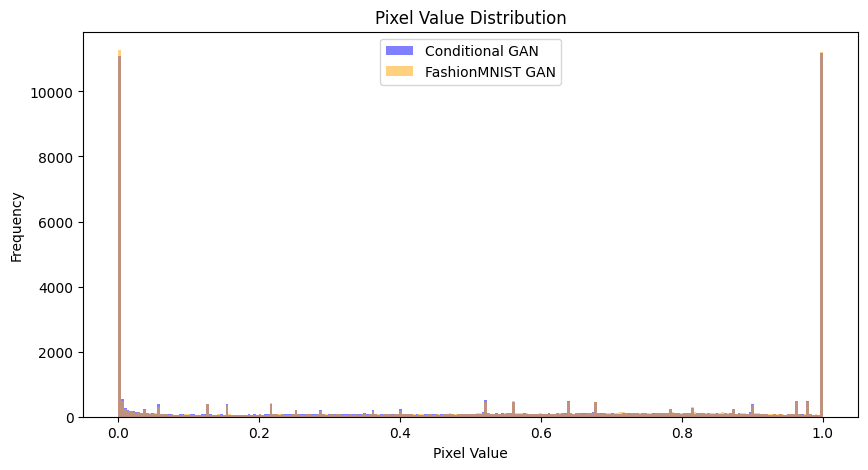

In [24]:
# --- 像素分布直方图比较 ---
def plot_pixel_distribution(img_conditional_np, img_gan_np):
    plt.figure(figsize=(10, 5))
    plt.hist(img_conditional_np, bins=256, alpha=0.5, label="Conditional GAN", color="blue")
    plt.hist(img_gan_np, bins=256, alpha=0.5, label="FashionMNIST GAN", color="orange")
    plt.title("Pixel Value Distribution")
    plt.xlabel("Pixel Value")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()

# --- 加载并处理图片 ---
# 加载图片
img_conditional = Image.open("fashionmnist_conditional_gan.png").convert('L')
img_gan = Image.open("fashionmnist_gan.png").convert('L')

# 调整尺寸一致
img_conditional_resized = img_conditional.resize((28 * 8, 28 * 8))  # 8行8列
img_gan_resized = img_gan.resize((28 * 8, 28 * 8))

# 将像素值归一化到 [0, 1]
img_conditional_np = np.array(img_conditional_resized).flatten() / 255.0
img_gan_np = np.array(img_gan_resized).flatten() / 255.0

# --- 统计信息计算 ---
# 均值和标准差
real_mean, real_std = img_conditional_np.mean(), img_conditional_np.std()
fake_mean, fake_std = img_gan_np.mean(), img_gan_np.std()
mean_diff = abs(real_mean - fake_mean)
std_diff = abs(real_std - fake_std)

# 计算直方图相似性（基于交集）
hist_real, _ = np.histogram(img_conditional_np, bins=256, range=(0, 1))
hist_fake, _ = np.histogram(img_gan_np, bins=256, range=(0, 1))
hist_sim = np.sum(np.minimum(hist_real, hist_fake)) / np.sum(hist_real)

# 打印统计结果
print(f"Real images - Mean: {real_mean:.4f}, Std: {real_std:.4f}")
print(f"Fake images - Mean: {fake_mean:.4f}, Std: {fake_std:.4f}")
print(f"Mean difference: {mean_diff:.4f}")
print(f"Std difference: {std_diff:.4f}")
print(f"Histogram similarity: {hist_sim:.4f}")

# --- 显示像素分布直方图 ---
plot_pixel_distribution(img_conditional_np, img_gan_np)
